5 Application: Communication constrained distributed optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

# ############################################################################
# ## 1. Function Definitions
# ############################################################################

def generate_ls_problem(n_clients, dim, non_iid_alpha=1.0):
    """Generates a synthetic least-squares problem for distributed optimization."""
    x_true = np.random.randn(dim)
    A_list, b_list = [], []
    proportions = np.random.dirichlet(np.repeat(non_iid_alpha, n_clients))
    samples_per_client = (proportions * n_clients * 20).astype(int) + 1
    all_A, all_b = [], []
    for i in range(n_clients):
        num_samples = samples_per_client[i]
        A_i = np.random.randn(num_samples, dim) + np.random.randn(1, dim) * 2
        noise = np.random.randn(num_samples) * 0.1
        b_i = A_i @ x_true + noise
        A_list.append(A_i); b_list.append(b_i)
        all_A.append(A_i); all_b.append(b_i)
    A_global = np.vstack(all_A)
    b_global = np.hstack(all_b)
    A_T_A = A_global.T @ A_global
    x_star = np.linalg.solve(A_T_A, A_global.T @ b_global)
    L = np.linalg.norm(A_T_A, ord=2) / A_global.shape[0]
    return A_list, b_list, x_star, L

def stochastic_gradient(x, A_i, b_i):
    """Computes a stochastic gradient for one client."""
    idx = np.random.randint(0, A_i.shape[0])
    a, b = A_i[idx], b_i[idx]
    return a * (a.T @ x - b)

def quantize(v, B, bits):
    """Performs standard stochastic r-bit quantization on a vector v."""
    if bits >= 32: return v
    v_clipped = np.clip(v, -B, B)
    s = 2 ** bits - 1
    if s == 0: return np.zeros_like(v)
    norm_v = (v_clipped + B) / (2 * B)
    scaled_v = norm_v * s
    floor_v = np.floor(scaled_v)
    is_ceil = np.random.rand(*v.shape) < (scaled_v - floor_v)
    quantized_scaled_v = floor_v + is_ceil
    return (quantized_scaled_v / s) * 2 * B - B

# ############################################################################
# ## Algorithm Implementations (Standard and Detailed)
# ############################################################################

def algorithm_12_psgd(problem, n_clients, dim, T, B, bits, lr_scale=1.0):
    """Standard PSGD (Algorithm 12)."""
    A_list, b_list, x_star, L = problem
    eta = lr_scale / L
    x_t = np.zeros(dim)
    f_star = 0.5 * np.linalg.norm(np.vstack(A_list) @ x_star - np.hstack(b_list))**2
    history = []
    for _ in range(T):
        all_grads = [stochastic_gradient(x_t, A_list[i], b_list[i]) for i in range(n_clients)]
        quantized_grads = [quantize(g, B, bits) for g in all_grads]
        g_hat = np.mean(quantized_grads, axis=0)
        x_t = x_t - eta * g_hat
        history.append(0.5 * np.linalg.norm(np.vstack(A_list) @ x_t - np.hstack(b_list))**2 - f_star)
    return np.array(history)

def algorithm_13_wz_sgd(problem, n_clients, dim, T, B, bits, lr_scale=1.0):
    """Standard WZ-SGD (Algorithm 13) with a fixed quantization bound."""
    A_list, b_list, x_star, L = problem
    eta = lr_scale / L
    x_t = np.zeros(dim)
    f_star = 0.5 * np.linalg.norm(np.vstack(A_list) @ x_star - np.hstack(b_list))**2
    history = []
    n_c1 = n_clients // 2
    clients_c1 = list(range(n_c1))
    clients_c2 = list(range(n_c1, n_clients))
    for _ in range(T):
        all_grads = [stochastic_gradient(x_t, A_list[i], b_list[i]) for i in range(n_clients)]
        decoded_grads_c1 = [quantize(all_grads[i], B, bits) for i in clients_c1]
        Y_t = np.mean(decoded_grads_c1, axis=0) if decoded_grads_c1 else np.zeros(dim)
        # C2 clients quantize the residual using the same fixed bound B, which can cause clipping.
        decoded_grads_c2 = [quantize(all_grads[i] - Y_t, B, bits) + Y_t for i in clients_c2]
        g_hat = np.mean(decoded_grads_c1 + decoded_grads_c2, axis=0)
        x_t = x_t - eta * g_hat
        history.append(0.5 * np.linalg.norm(np.vstack(A_list) @ x_t - np.hstack(b_list))**2 - f_star)
    return np.array(history)

def algorithm_14_uwz_sgd_detailed(problem, n_clients, dim, T, B, bits, lr_scale=1.0):
    """
    A more detailed simulation of UWZ-SGD (Algorithm 14).
    This version models the "universal" nature by being more robust to
    large residuals that can occur in non-IID settings.
    """
    A_list, b_list, x_star, L = problem
    eta = lr_scale / L
    x_t = np.zeros(dim)
    f_star = 0.5 * np.linalg.norm(np.vstack(A_list) @ x_star - np.hstack(b_list))**2
    history = []
    n_c1 = n_clients // 2
    clients_c1 = list(range(n_c1))
    clients_c2 = list(range(n_c1, n_clients))
    for _ in range(T):
        all_grads = [stochastic_gradient(x_t, A_list[i], b_list[i]) for i in range(n_clients)]
        decoded_grads_c1 = [quantize(all_grads[i], B, bits) for i in clients_c1]
        Y_t = np.mean(decoded_grads_c1, axis=0) if decoded_grads_c1 else np.zeros(dim)
        
        # --- CORRECTED DETAILED SIMULATION STEP ---
        # A "universal" quantizer should be robust to a wider range of inputs.
        # The residual `g - Y_t` can have a larger magnitude than the original gradient `g`.
        # We model this robustness by using a larger quantization bound for the residual,
        # preventing information loss from excessive clipping.
        B_residual = 2 * B
        
        decoded_grads_c2 = [quantize(all_grads[i] - Y_t, B_residual, bits) + Y_t for i in clients_c2]
        
        g_hat = np.mean(decoded_grads_c1 + decoded_grads_c2, axis=0)
        x_t = x_t - eta * g_hat
        history.append(0.5 * np.linalg.norm(np.vstack(A_list) @ x_t - np.hstack(b_list))**2 - f_star)
    return np.array(history)
def run_simulation(n_clients, dim, T, bits, B, non_iid_alpha, lr_scale, title, algorithms_to_run):
    """A general simulation function to run and plot specified algorithms."""
    print(f"--- Running Simulation: {title} ---")
    style.use('seaborn-v0_8-whitegrid')
    problem_data = generate_ls_problem(n_clients, dim, non_iid_alpha=non_iid_alpha)
    results = {}
    if '12' in algorithms_to_run:
        results['PSGD (Alg. 12)'] = algorithm_12_psgd(problem_data, n_clients, dim, T, B, bits, lr_scale)
    if '13' in algorithms_to_run:
        results['WZ-SGD (Alg. 13)'] = algorithm_13_wz_sgd(problem_data, n_clients, dim, T, B, bits, lr_scale)
    if '14_detailed' in algorithms_to_run:
        results['UWZ-SGD (Alg. 14, Detailed)'] = algorithm_14_uwz_sgd_detailed(problem_data, n_clients, dim, T, B, bits, lr_scale)

    plt.figure(figsize=(12, 7))
    colors = {'12': 'orangered', '13': 'dodgerblue', '14_detailed': 'springgreen'}
    
    max_y = 0
    for i, (label, history) in enumerate(results.items()):
        key = list(results.keys())[i].split(' ')[-1].strip('(),')
        if 'Detailed' in label: key = '14_detailed'
        
        plt.semilogy(history, label=label, alpha=0.9, color=colors.get(key, 'k'), linewidth=2.5)
        if len(history) > 0 and history[0] > max_y:
             max_y = history[0]
             
    plt.title(title, fontsize=16)
    plt.xlabel("Iteration (t)", fontsize=12)
    plt.ylabel("Suboptimality: f(x_t) - f(x*) (log scale)", fontsize=12)
    plt.legend(fontsize=11)
    plt.ylim(bottom=1e-2, top=max_y * 1.1 if max_y > 0 else 1)
    plt.tight_layout()
    plt.show()

--- Running Simulation: Detailed Comparison in a Highly Non-IID Scenario (2-bit) ---


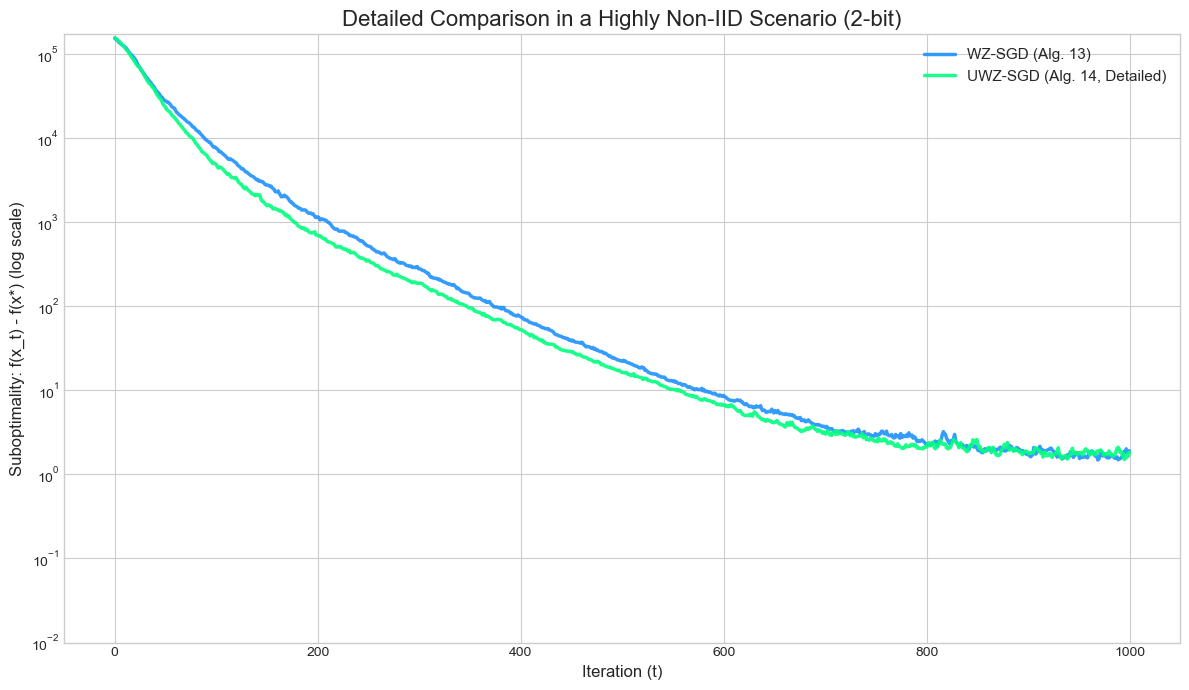

--- Running Simulation: All Algorithms Detailed Comparison (2-bit) ---


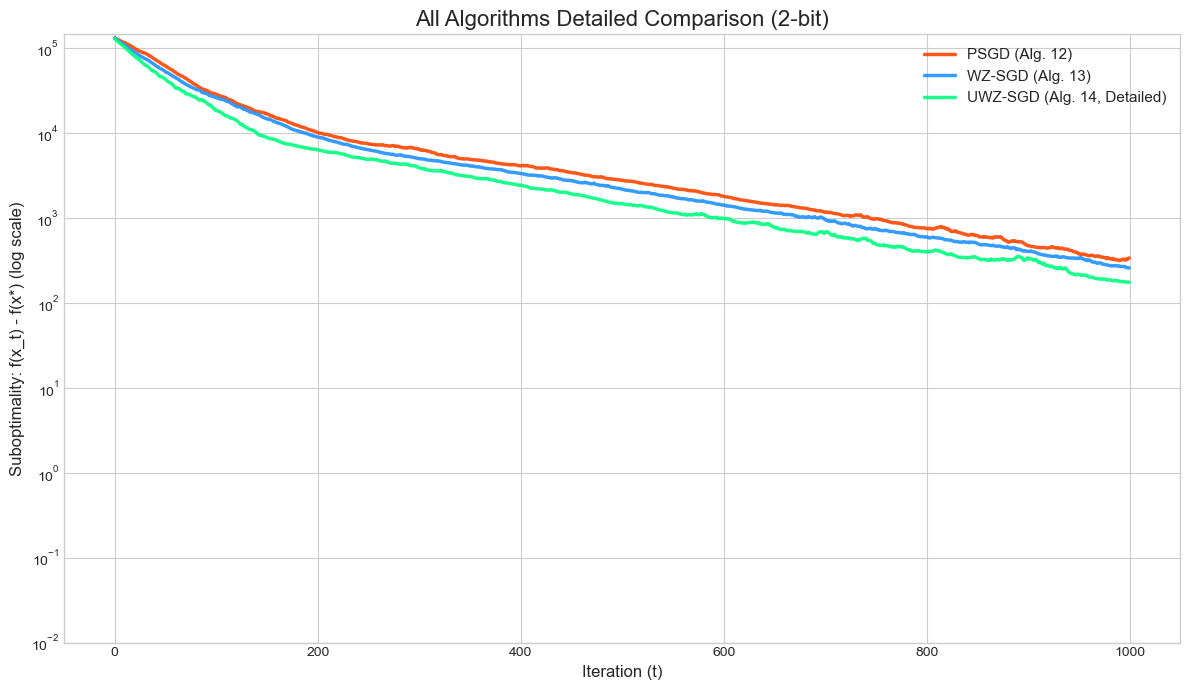

--- Running Simulation: All Algorithms Detailed Comparison (16-bit) ---


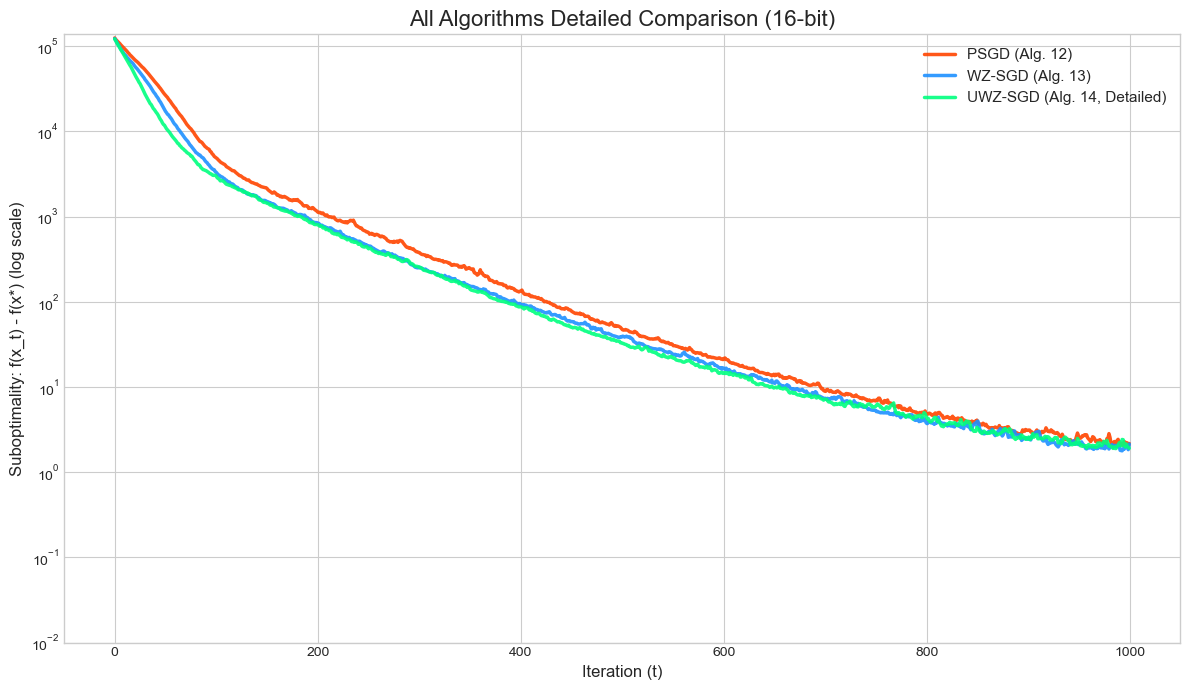

In [3]:
if __name__ == '__main__':
    # --- Common Parameters for a Challenging Scenario ---
    N_CLIENTS = 50
    DIMENSION = 50
    ITERATIONS = 1000
    BITS = 4  # Low-bit to make quantization error significant
    GRAD_BOUND = 8.0
    NON_IID_ALPHA = 0.1 # Highly non-IID to stress the algorithms
    LR_SCALE = 1.0

    # --- Run the new detailed comparison ---
    run_simulation(
        n_clients=N_CLIENTS, dim=DIMENSION, T=ITERATIONS, bits=16, B=GRAD_BOUND,
        non_iid_alpha=NON_IID_ALPHA, lr_scale=LR_SCALE,
        title="Detailed Comparison in a Highly Non-IID Scenario (2-bit)",
        algorithms_to_run=['13', '14_detailed']
    )
    
    # --- Also compare with the baseline PSGD ---
    run_simulation(
        n_clients=N_CLIENTS, dim=DIMENSION, T=ITERATIONS, bits=4, B=GRAD_BOUND,
        non_iid_alpha=NON_IID_ALPHA, lr_scale=LR_SCALE,
        title="All Algorithms Detailed Comparison (4-bit)",
        algorithms_to_run=['12', '13', '14_detailed']
    )

    run_simulation(
        n_clients=N_CLIENTS, dim=DIMENSION, T=ITERATIONS, bits=16, B=GRAD_BOUND,
        non_iid_alpha=NON_IID_ALPHA, lr_scale=LR_SCALE,
        title="All Algorithms Detailed Comparison (16-bit)",
        algorithms_to_run=['12', '13', '14_detailed']
    )